In [1]:
import numpy as np
from scipy.signal import fftconvolve

def degrade_image(image, kernel, noise):
    # Convolve image with kernel using FFT
    convolved = fftconvolve(image, kernel, mode='same')
    # Add noise realization
    degraded = convolved + noise
    return degraded

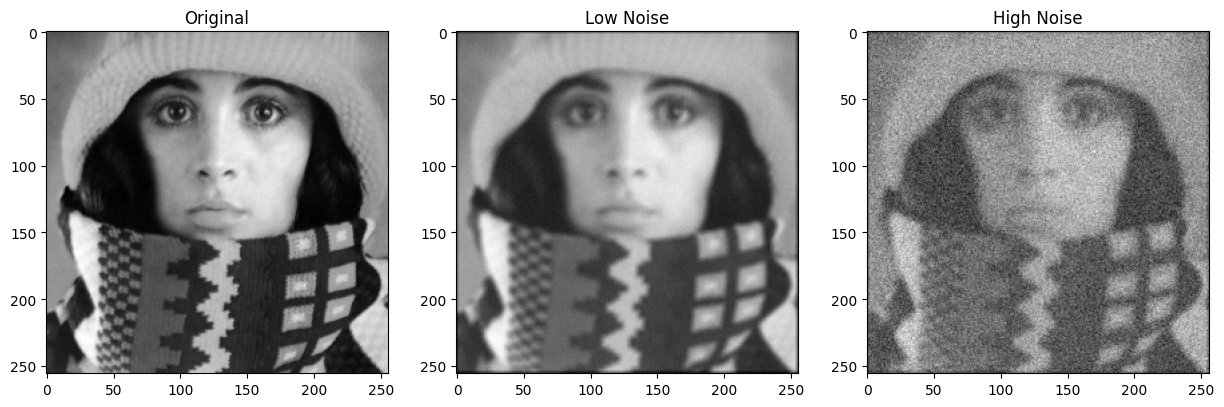

In [5]:
import matplotlib.pyplot as plt
from skimage import io, color, util

# Load image directly as grayscale (no need for rgb2gray conversion)
image = io.imread('../TestImages/Week 1/trui.png', as_gray=True)
image = util.img_as_float(image)  # Ensure float dtype [0, 1]
image = util.img_as_float(image)

# Create Gaussian kernel
def gaussian_kernel(size=5, sigma=3):
    ax = np.arange(-size//2 + 1, size//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

kernel = gaussian_kernel()

# Generate noise with different levels
noise_low = np.random.normal(0, 0.01, image.shape)
noise_high = np.random.normal(0, 0.1, image.shape)

# Degrade image
degraded_low = degrade_image(image, kernel, noise_low)
degraded_high = degrade_image(image, kernel, noise_high)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(degraded_low, cmap='gray')
axes[1].set_title('Low Noise')
axes[2].imshow(degraded_high, cmap='gray')
axes[2].set_title('High Noise')
plt.show()

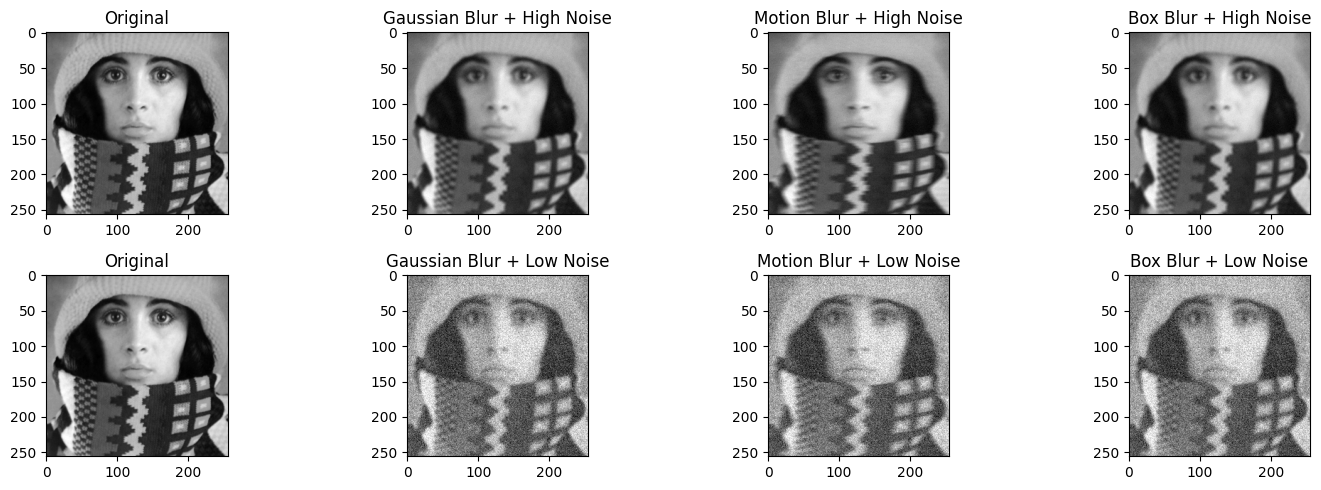

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, util
from scipy.signal import convolve2d

# Load image directly as grayscale
image = io.imread('../TestImages/Week 1/trui.png', as_gray=True)
image = util.img_as_float(image)  # Ensure float dtype [0, 1]

# Define different kernels
def gaussian_kernel(size=5, sigma=3):
    """Creates a Gaussian kernel."""
    ax = np.arange(-size//2 + 1, size//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

def motion_blur_kernel(size=9):
    """Creates a horizontal motion blur kernel."""
    kernel = np.zeros((size, size))
    kernel[size//2, :] = 1.0 / size
    return kernel

def box_blur_kernel(size=5):
    """Creates a simple box blur kernel."""
    return np.ones((size, size)) / (size * size)

# Select different kernels
kernel_gaussian = gaussian_kernel(size=5, sigma=3)
kernel_motion = motion_blur_kernel(size=9)
kernel_box = box_blur_kernel(size=5)

# Function to degrade image
def degrade_image(image, kernel, noise):
    """Applies convolution with a kernel and adds noise."""
    blurred = convolve2d(image, kernel, mode='same', boundary='symm')
    noisy = blurred + noise
    return np.clip(noisy, 0, 1)  # Ensure values remain within [0,1]

# Generate noise with different levels
noise_low = np.random.normal(0, 0.01, image.shape)
noise_high = np.random.normal(0, 0.1, image.shape)

# Apply different degradations
degraded_gaussian = degrade_image(image, kernel_gaussian, noise_low)
degraded_motion = degrade_image(image, kernel_motion, noise_low)
degraded_box = degrade_image(image, kernel_box, noise_low)

# Apply different degradations
degraded_gaussian1 = degrade_image(image, kernel_gaussian, noise_high)
degraded_motion1 = degrade_image(image, kernel_motion, noise_high)
degraded_box1 = degrade_image(image, kernel_box, noise_high)

# Display results
fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes[0][0].imshow(image, cmap='gray')
axes[0][0].set_title('Original')
axes[0][1].imshow(degraded_gaussian, cmap='gray')
axes[0][1].set_title('Gaussian Blur + High Noise')
axes[0][2].imshow(degraded_motion, cmap='gray')
axes[0][2].set_title('Motion Blur + High Noise')
axes[0][3].imshow(degraded_box, cmap='gray')
axes[0][3].set_title('Box Blur + High Noise')

# Display results
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[1][0].imshow(image, cmap='gray')
axes[1][0].set_title('Original')
axes[1][1].imshow(degraded_gaussian1, cmap='gray')
axes[1][1].set_title('Gaussian Blur + Low Noise')
axes[1][2].imshow(degraded_motion1, cmap='gray')
axes[1][2].set_title('Motion Blur + Low Noise')
axes[1][3].imshow(degraded_box1, cmap='gray')
axes[1][3].set_title('Box Blur + Low Noise')

plt.tight_layout()
plt.show()


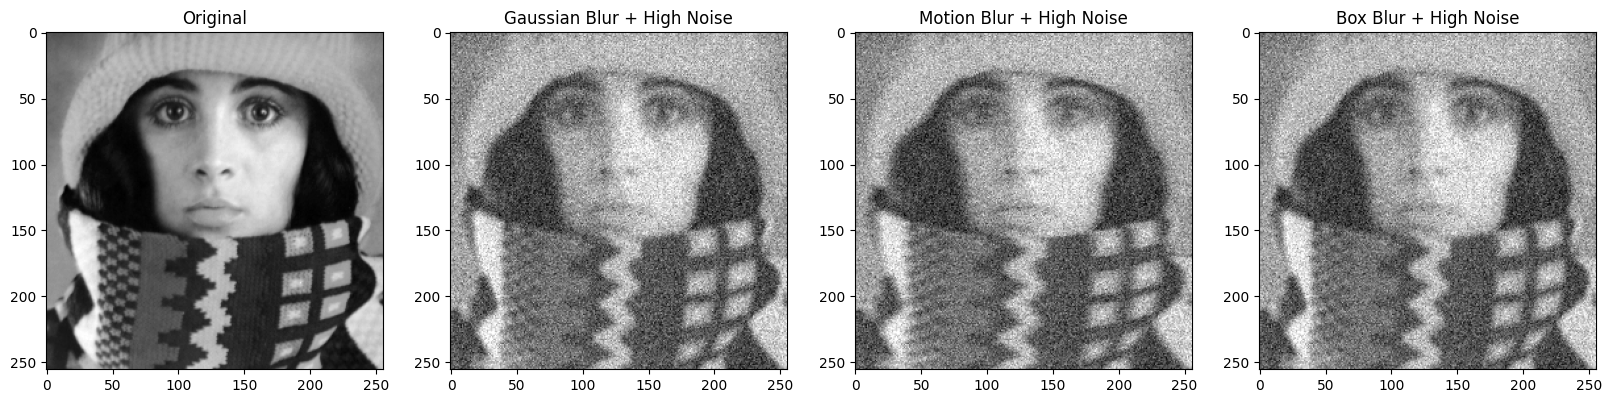

In [15]:
# Apply different degradations
degraded_gaussian = degrade_image(image, kernel_gaussian, noise_high)
degraded_motion = degrade_image(image, kernel_motion, noise_high)
degraded_box = degrade_image(image, kernel_box, noise_high)

# Display results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(degraded_gaussian, cmap='gray')
axes[1].set_title('Gaussian Blur + High Noise')
axes[2].imshow(degraded_motion, cmap='gray')
axes[2].set_title('Motion Blur + High Noise')
axes[3].imshow(degraded_box, cmap='gray')
axes[3].set_title('Box Blur + High Noise')

plt.show()

In [6]:
# code for 1.2

In [7]:
def direct_inverse_filter(degraded, kernel):
    # Compute FFT of degraded image
    G = np.fft.fft2(degraded)
    
    # Pad kernel to image size and center it
    pad_rows = degraded.shape[0] - kernel.shape[0]
    pad_cols = degraded.shape[1] - kernel.shape[1]
    kernel_padded = np.pad(kernel, ((0, pad_rows), (0, pad_cols)), mode='constant')
    kernel_padded = np.fft.ifftshift(kernel_padded)
    
    # Compute H and avoid division by zero
    H = np.fft.fft2(kernel_padded)
    H_mag = np.abs(H)
    H[H_mag < 1e-6] = 1e-6  # Threshold to prevent division by zero
    
    # Inverse filtering
    F_hat = G / H
    restored = np.fft.ifft2(F_hat).real
    return np.clip(restored, 0, 1)  # Clip to valid pixel range

In [8]:
# code for 1.3

In [10]:
def wiener_filter(degraded, kernel, K):
    G = np.fft.fft2(degraded)
    
    # Pad and center kernel
    pad_rows = degraded.shape[0] - kernel.shape[0]
    pad_cols = degraded.shape[1] - kernel.shape[1]
    kernel_padded = np.pad(kernel, ((0, pad_rows), (0, pad_cols)), mode='constant')
    kernel_padded = np.fft.ifftshift(kernel_padded)
    H = np.fft.fft2(kernel_padded)
    
    # Compute Wiener filter
    H_conj = np.conj(H)
    H_mag_sq = H * H_conj
    F_hat = (H_conj / (H_mag_sq + K)) * G
    restored = np.fft.ifft2(F_hat).real
    return np.clip(restored, 0, 1)
    